<a href="https://colab.research.google.com/github/Imajitdas7/E-Commerce-forecasting/blob/main/Ecommerce_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [104]:
data = pd.read_csv("/content/e-commerce_data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})

In [105]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [106]:
data.shape

(541909, 8)

In [107]:
data.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
428347,573422,23497,CLASSIC CHROME BICYCLE BELL,12,10/31/2011 9:51,1.45,14292,United Kingdom
103322,545060,82600,NO SINGING METAL SIGN,3,2/27/2011 13:47,2.10,15547,United Kingdom
281782,561600,22417,PACK OF 60 SPACEBOY CAKE CASES,3,7/28/2011 11:29,0.55,15861,United Kingdom
455679,575637,72351B,SET/6 PINK BUTTERFLY T-LIGHTS,3,11/10/2011 13:46,2.10,16904,United Kingdom
49074,540501,22345,PARTY PIZZA DISH BLUE POLKADOT,24,1/9/2011 10:43,0.21,13162,United Kingdom
211469,555383,84987,SET OF 36 TEATIME PAPER DOILIES,1,6/2/2011 15:13,1.45,12517,Germany
219491,556095,22422,TOOTHPASTE TUBE PEN,1,6/8/2011 15:27,1.25,NaN,United Kingdom
299265,563093,47566,PARTY BUNTING,2,8/11/2011 17:28,10.79,NaN,United Kingdom
124471,546977,85099C,JUMBO BAG BAROQUE BLACK WHITE,7,3/18/2011 12:08,4.13,NaN,United Kingdom
34271,539326,22720,SET OF 3 CAKE TINS PANTRY DESIGN,7,12/17/2010 9:22,4.95,14560,United Kingdom


Check Missing Values

In [108]:
pd.isnull(data).sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [109]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


Almost 25 % of the customers are unknown! That's very strange. In addition we have 0.2 % of missing descriptions. This looks dirty. Let's gain a further impression by considering some examples.

In [110]:
#  Missing descriptions

data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


**How often do we miss the customer as well?**

In [111]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

,count
CustomerID,
True,1454


**And the unit price?**

In [112]:
data[data.Description.isnull()].UnitPrice.value_counts()

,count
UnitPrice,
0.0,1454


In **cases of missing descriptions we always miss the customer and the unit price as well**. Why does the retailer records such kind of entries without a further description? It seems that there is no sophisticated procedure how to deal with and record such kind of transactions. This is already a hint that **we could expect strange entries in our data and that it can be difficult to detect them**!

In [113]:
#  Missing Customer IDs

data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [114]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


That's bad as well. **The price and the quantities of entries without a customer ID can show extreme outliers**. As we might want to create features later on that are based on historical prices and sold quantities, this is very disruptive. Our first **advice for the retailer is to setup strategies for transactions that are somehow faulty or special**. And the question remains: Why is it possible for a transaction to be without a customer ID. Perhaps you can purchase as a quest but then it would of a good and clean style to plugin a special ID that indicates that this one is a guest. Ok, next one: Do we have hidden nan-values in Descriptions? To find it out, let's create a new feature that hold descriptions in lowercase:

**Hidden missing descriptions**

Can we find "nan"-Strings?

In [115]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,539724
True,731


Can we find empty ""-strings?

In [116]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

,count
lowercase_descriptions,
False,540455


We found **additional, hidden nan-values that show a string "nan" instead of a nan-value**. Let's transform them to NaN:

In [117]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

As we don't know why customers or descriptions are missing and we have seen strange outliers in quantities and prices as well as zero-prices, **let's play safe and drop all of these occurences**.

In [118]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

Just to be sure: Is there a missing value left?

In [119]:
data.isnull().sum().sum()

0

### The Time period <a class="anchor" id="timeperiod"></a>

How long is the period in days?

In [120]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [121]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


### The invoice number <a class="anchor" id="invoiceno"></a>

How many different invoice numbers do we have?

In [122]:
data.InvoiceNo.nunique()

22186

In the data description we can find that a cancelled transactions starts with a "C" in front of it. Let's create a feature to easily filter out these cases:

In [123]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

,count
IsCancelled,
False,97.81007
True,2.18993


2,2 % of all entries are cancellations.  

In [124]:
data.loc[data.IsCancelled==True].describe()

,Quantity,InvoiceDate,UnitPrice
count,8896.000000,8896,8896.000000
mean,-30.882981,2011-06-27 06:10:27.308902912,18.862815
min,-80995.000000,2010-12-01 09:41:00,0.010000
25%,-6.000000,2011-03-22 16:07:00,1.450000
50%,-2.000000,2011-07-11 13:51:00,2.950000
75%,-1.000000,2011-10-06 20:36:00,4.950000
max,-1.000000,2011-12-09 11:58:00,38970.000000
std,1170.746458,NaN,444.590459


**All cancellations have negative quantites but positive, non-zero unit prices**. Given this data we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done. Let's drop them:

In [125]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

### Stockcodes <a class="anchor" id="stockcodes"></a>

```
```



How many unique stockcodes do we have?

In [126]:
data.StockCode.nunique()

3663

Which codes are most common?

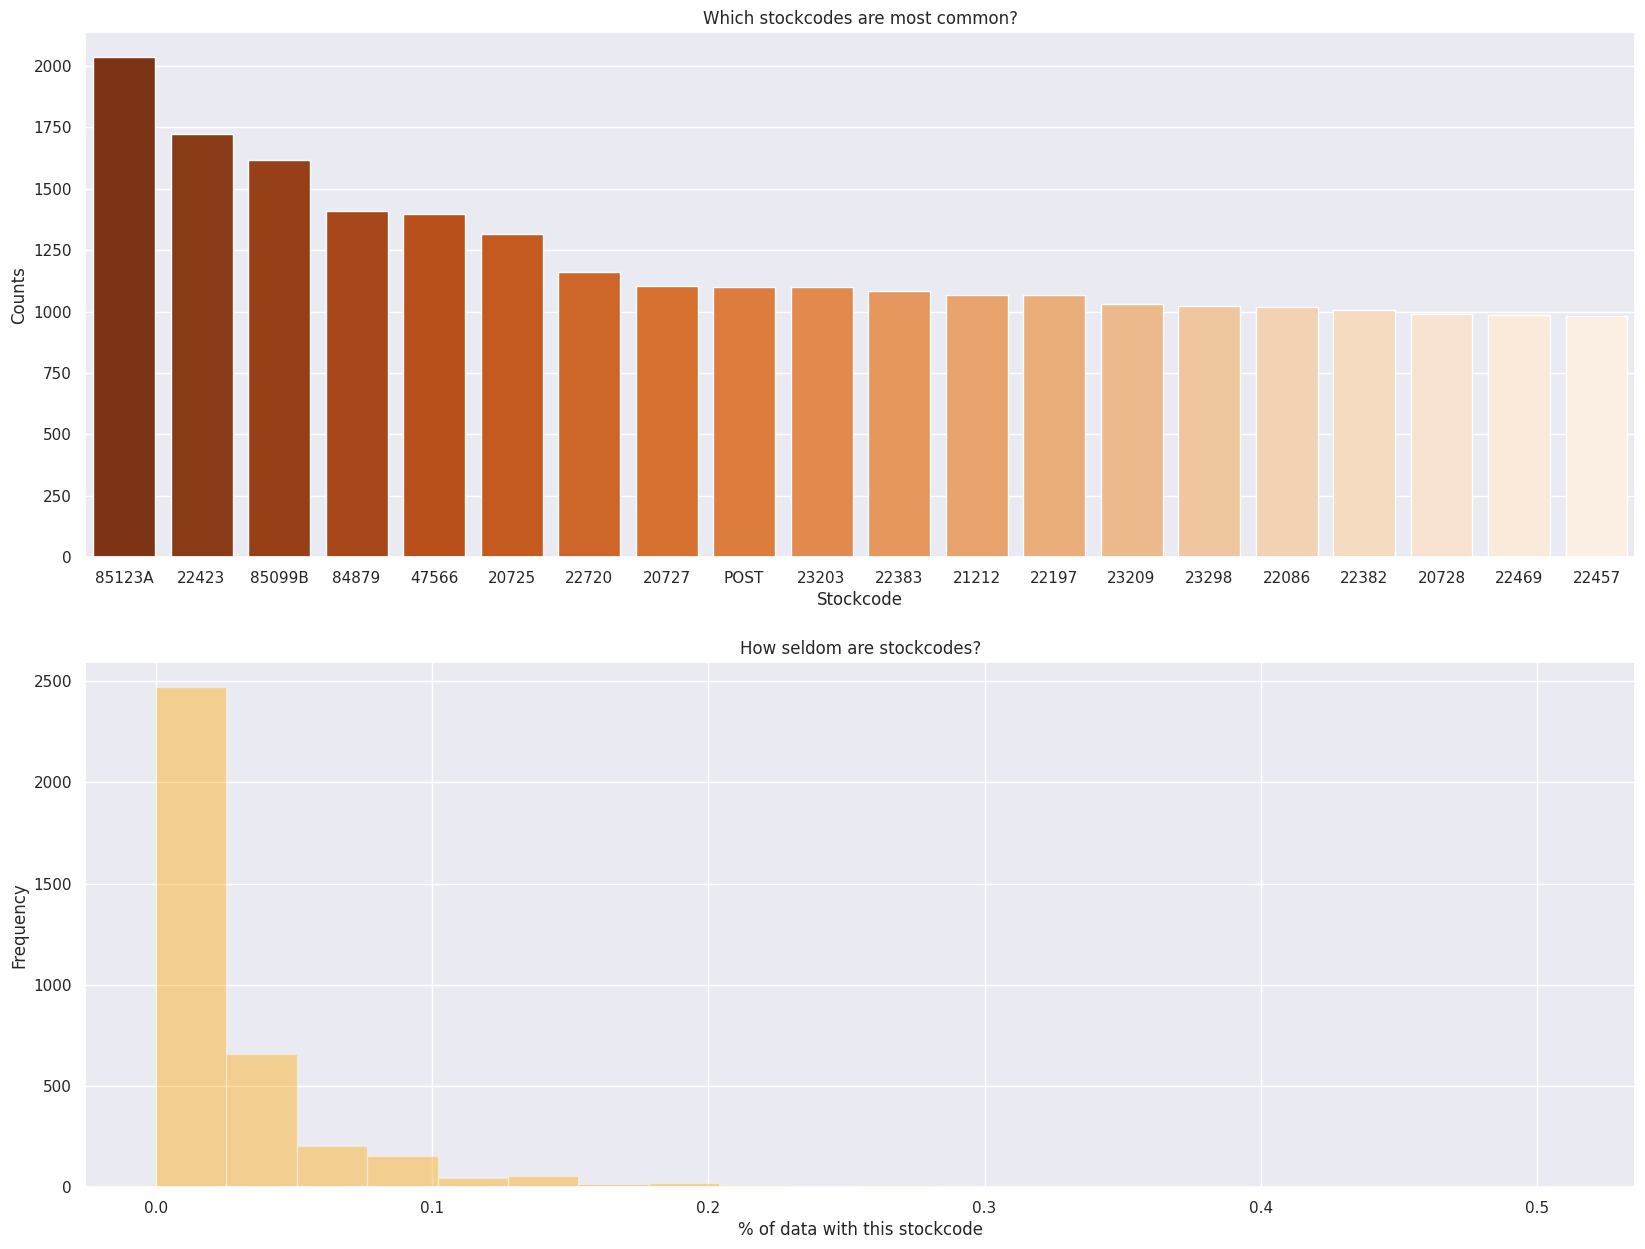

In [127]:
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))

# Pass x and y as keyword arguments
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax=ax[0], palette="Oranges_r")

ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

* Do you the the **POST** in the most common stockcode counts?! **That's a strange one!** Hence we could expect strange occurences not only in the descriptions and customerIDs but also in the stockcode. OHOHOH! It's code is shorter than the others as well as not numeric.
* Most stockcodes are very seldom. This indicates that the **retailer sells many different products** and that there is no strong secialization of a specific stockcode. Nevertheless we have to be careful as this must not mean that the retailer is not specialized given a specific product type. The stockcode could be a very detailed indicator that does not yield information of the type, for example water bottles may have very different variants in color, name and shapes but they are all water bottles.  

Let's count the number of numeric chars in and the length of the stockcode:

In [128]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

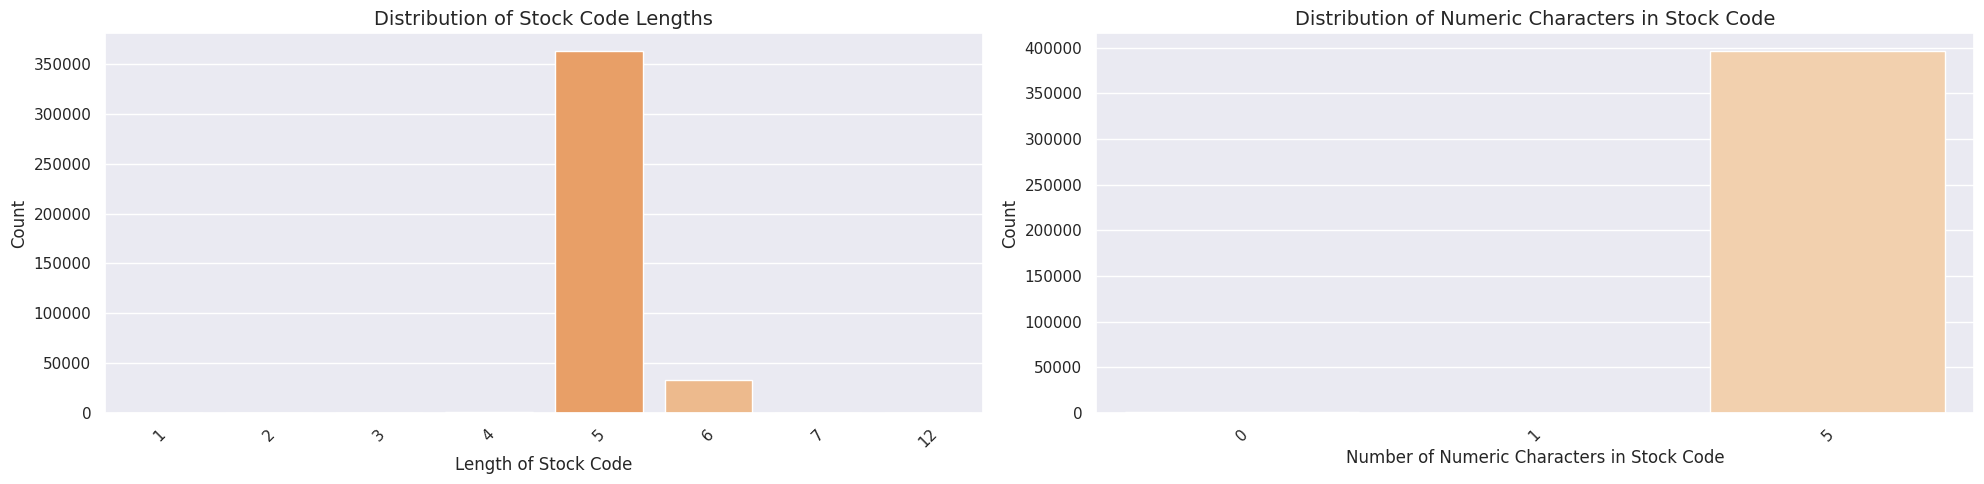

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot countplots
sns.countplot(x=data["StockCodeLength"], palette="Oranges_r", ax=ax[0])
sns.countplot(x=data["nNumericStockCode"], palette="Oranges_r", ax=ax[1])

# Set labels and titles
ax[0].set_xlabel("Length of Stock Code", fontsize=12)
ax[1].set_xlabel("Number of Numeric Characters in Stock Code", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)

ax[0].set_title("Distribution of Stock Code Lengths", fontsize=14)
ax[1].set_title("Distribution of Numeric Characters in Stock Code", fontsize=14)

# Rotate x-axis labels if needed
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)

# Show the plot
plt.tight_layout() # Changed from plt.tight_l to plt.tight_layout()

Even though the majority of samples has a stockcode that consists of 5 numeric chars, we can see that there are other occurences as well. The length can vary between 1 and 12 and there are stockcodes with no numeric chars at all!

In [130]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

,count
lowercase_descriptions,
postage,1099
manual,290
carriage,133
dotcom postage,16
bank charges,12
pads to match all cushions,4


Ihh, again something that we don't want to predict. Again this indicates that the retailer does not speparate well between special kind of transactions and valid customer-retailer transactions. Let's drop all of these occurences:

In [131]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [132]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

### Descriptions <a class="anchor" id="descriptions"></a>

How many unique descriptions do we have?

In [133]:
data.Description.nunique()

2983

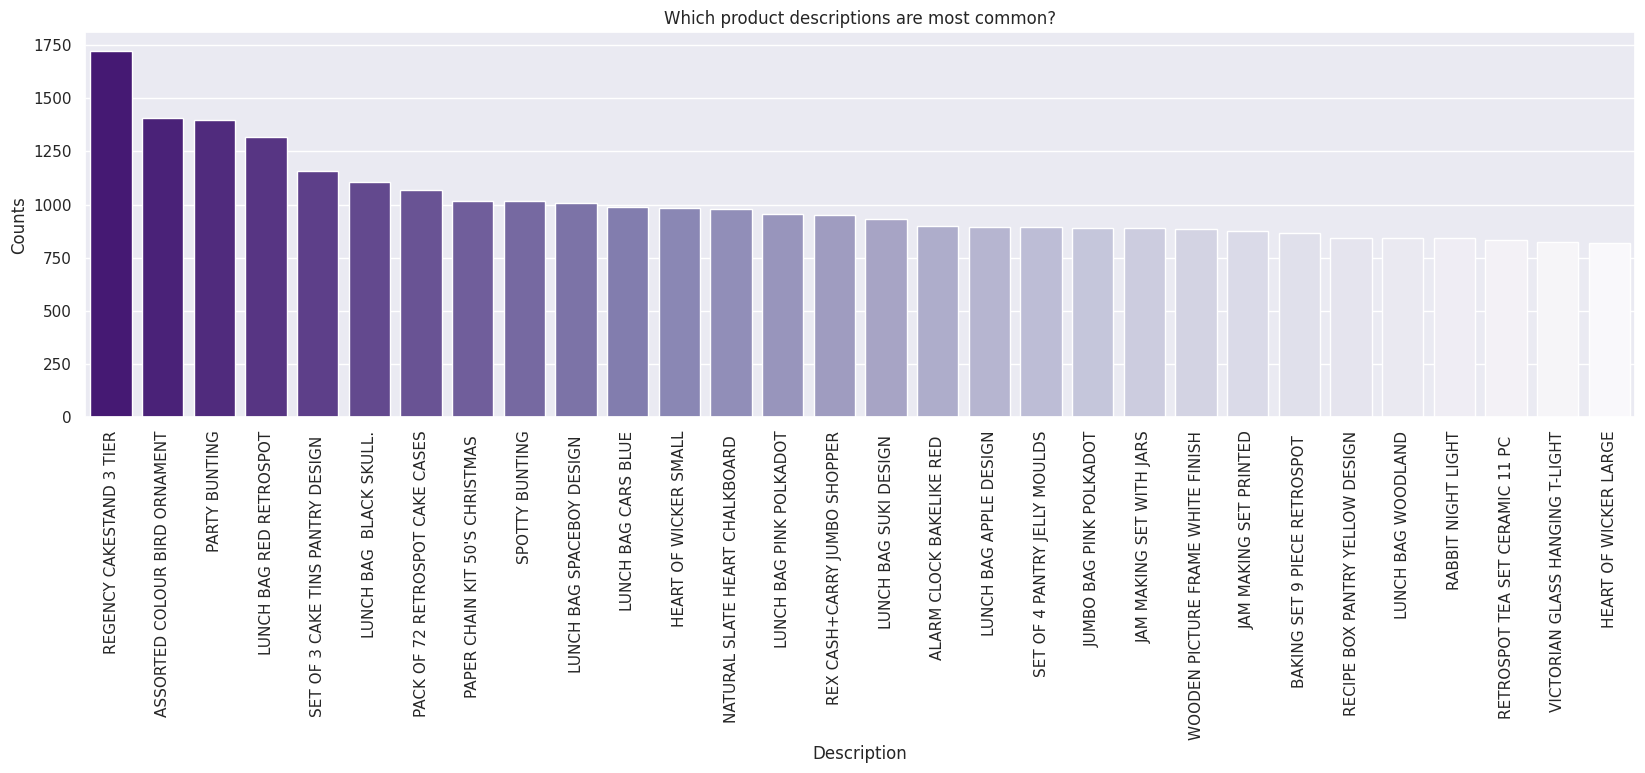

In [134]:
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
# Pass x and y as keyword arguments
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

Ok, we can see that **some descriptions correspond to a similar product type**. Do you see the multiple occurences of lunch bags? We often have **color information about the product** as well. Furthermore the most common descriptions seem to confirm that **the retailer sells various different kinds of products**. All descriptions seem to consist of **uppercase chars**. Ok, now let's do some addtional analysis on the descriptions by counting the length and the number of lowercase chars.

In [135]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [136]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

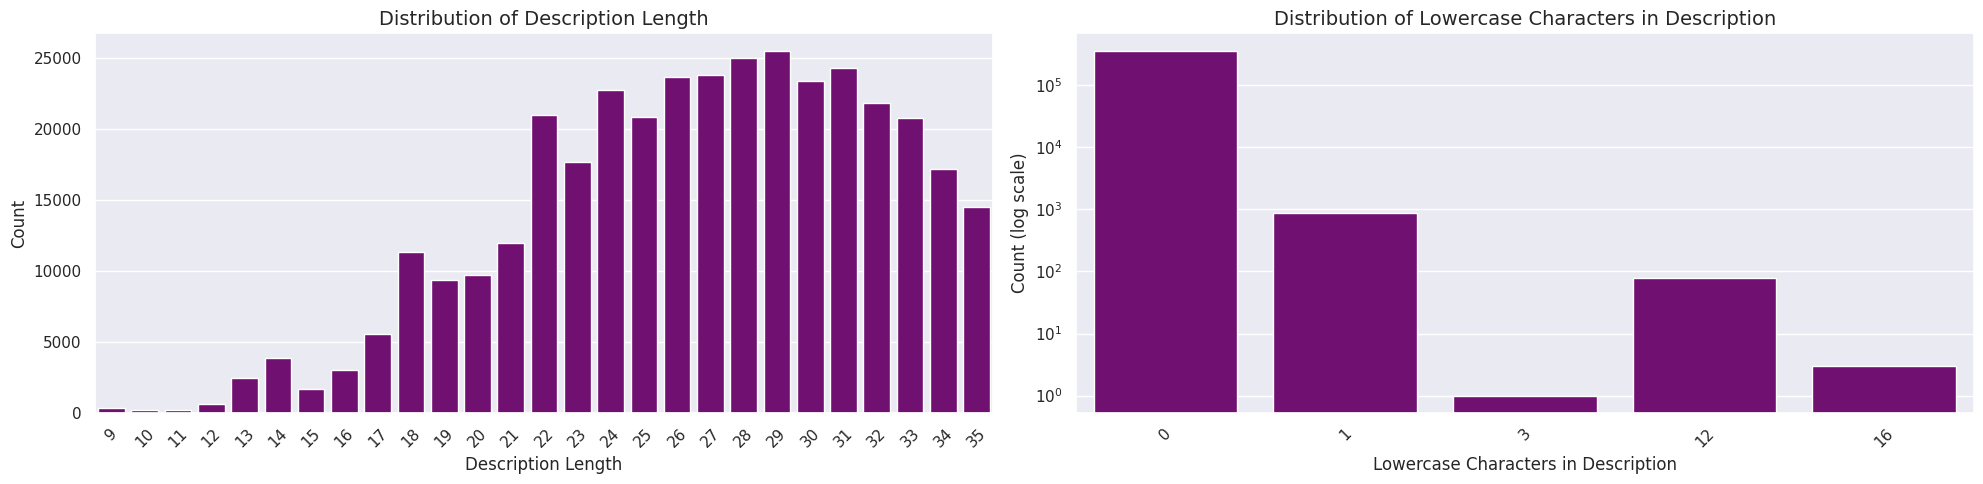

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Count plots
sns.countplot(x=data["DescriptionLength"], ax=ax[0], color="Purple")
sns.countplot(x=data["LowCharsInDescription"], ax=ax[1], color="Purple")

# Set labels and titles
ax[0].set_xlabel("Description Length", fontsize=12)
ax[1].set_xlabel("Lowercase Characters in Description", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[1].set_ylabel("Count (log scale)", fontsize=12)

ax[0].set_title("Distribution of Description Length", fontsize=14)
ax[1].set_title("Distribution of Lowercase Characters in Description", fontsize=14)

# Apply log scale to the second plot's y-axis
ax[1].set_yscale("log")

# Rotate x-axis labels if needed
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


Oh, great! **Almost all descriptions do not have a lowercase chars, but we have found exceptional cases!**

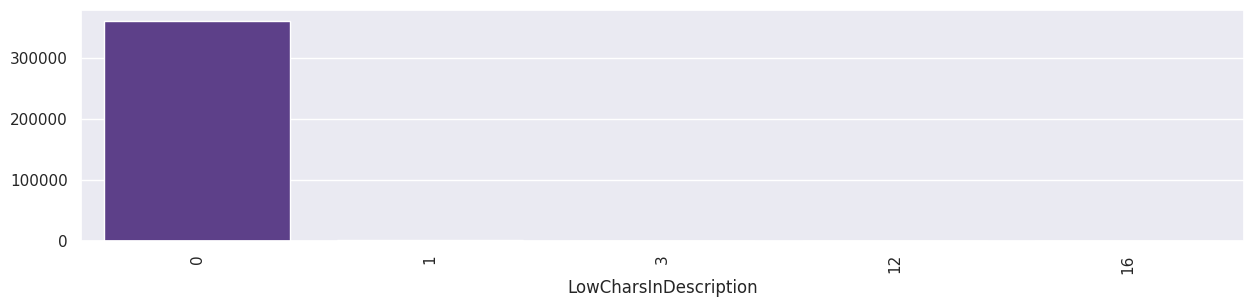

In [138]:
plt.figure(figsize=(15,3))
# Get value counts of "LowCharsInDescription" column from the DataFrame "data"
lowchar_counts = data["LowCharsInDescription"].value_counts()
# Plot the barplot
sns.barplot(x=lowchar_counts.index, y=lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

In [139]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [140]:
data.UpCharsInDescription.describe()

,UpCharsInDescription
count,362522.000000
mean,22.572291
std,4.354845
min,3.000000
25%,20.000000
50%,23.000000
75%,26.000000
max,32.000000


In [141]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

,count
Description,
Next Day Carriage,79
High Resolution Image,3


In [142]:
data = data.loc[data.UpCharsInDescription > 5].copy()

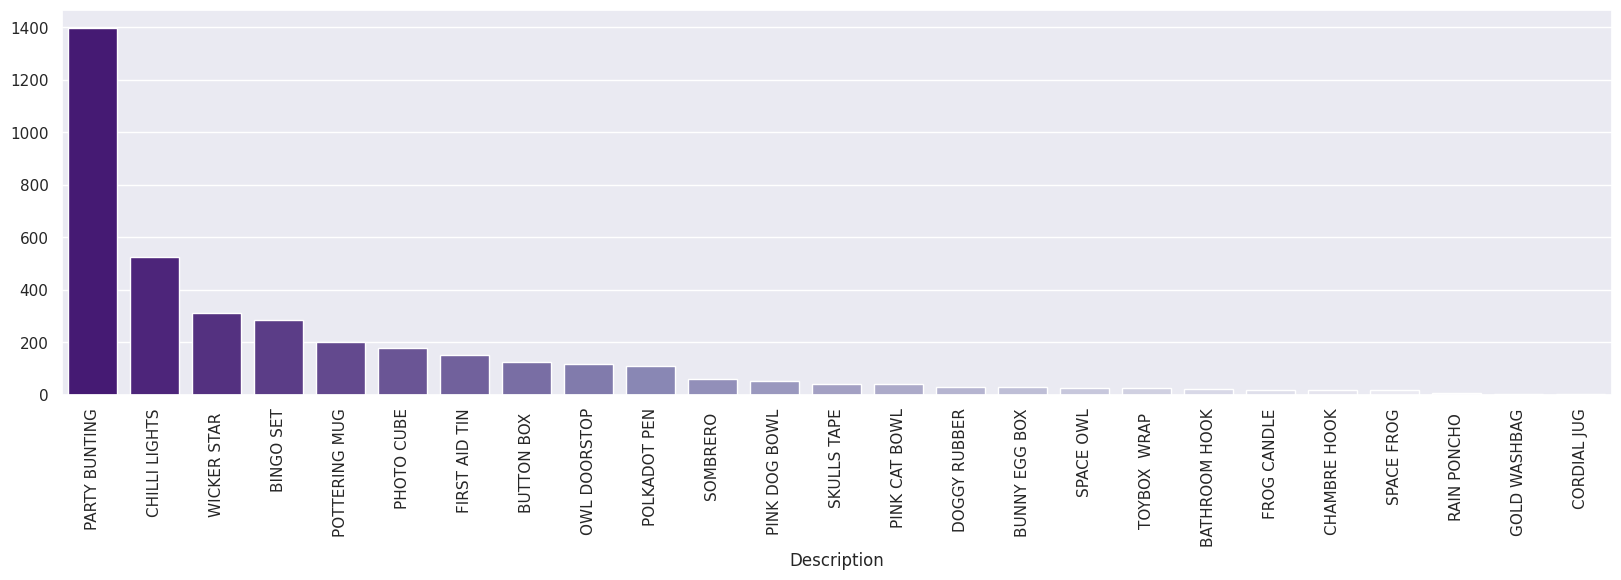

In [143]:
dlength_counts = data.loc[data.DescriptionLength < 14].Description.value_counts()

plt.figure(figsize=(20,5))
# Pass x and y as keyword arguments
sns.barplot(x=dlength_counts.index, y=dlength_counts.values, palette="Purples_r") # Changed to use keyword arguments
plt.xticks(rotation=90);

In [144]:
data.StockCode.nunique()

2781

In [145]:
data.Description.nunique()

2981

In [146]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

,Description
StockCode,
23236,4
23196,4
23413,3
23244,3
23126,3
23203,3
23209,3
23366,3
23131,3


In [147]:
data.loc[data.StockCode == "23244"].Description.value_counts()

,count
Description,
ROUND STORAGE TIN VINTAGE LEAF,96
STORAGE TIN VINTAGE LEAF,7
CANNISTER VINTAGE LEAF DESIGN,2


In [148]:
data.CustomerID.nunique()

4315

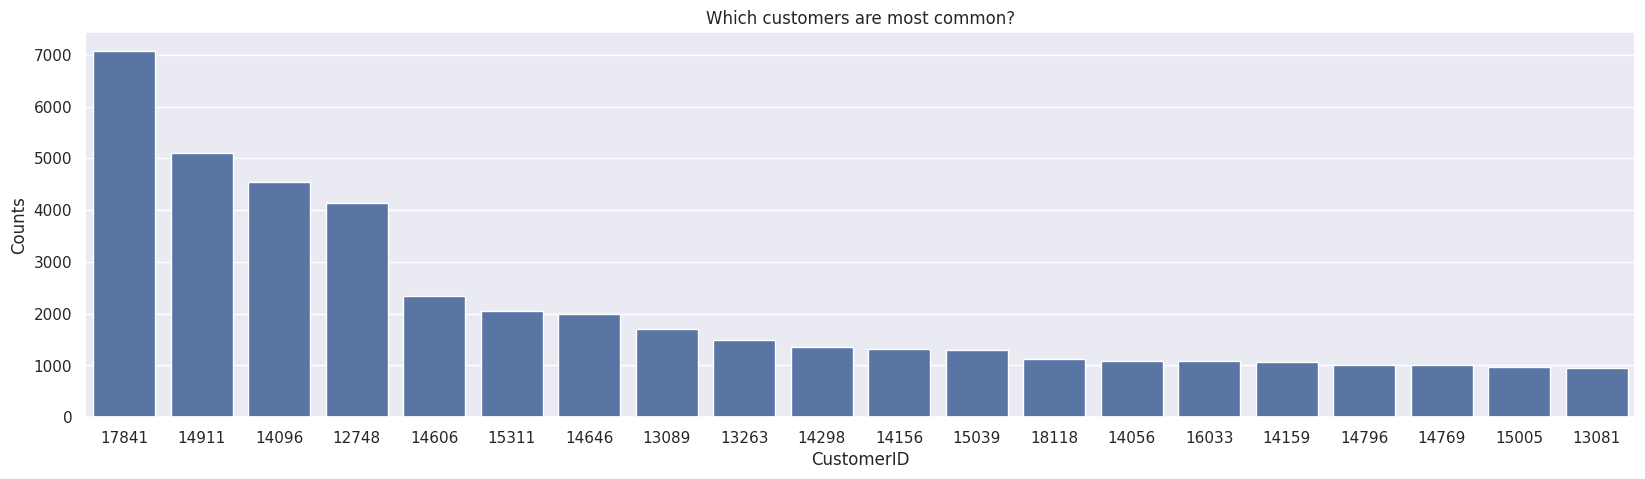

In [149]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
# Pass x and y as keyword arguments to sns.barplot
sns.barplot(x=customer_counts.index, y=customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

In [150]:
data.Country.nunique()

37

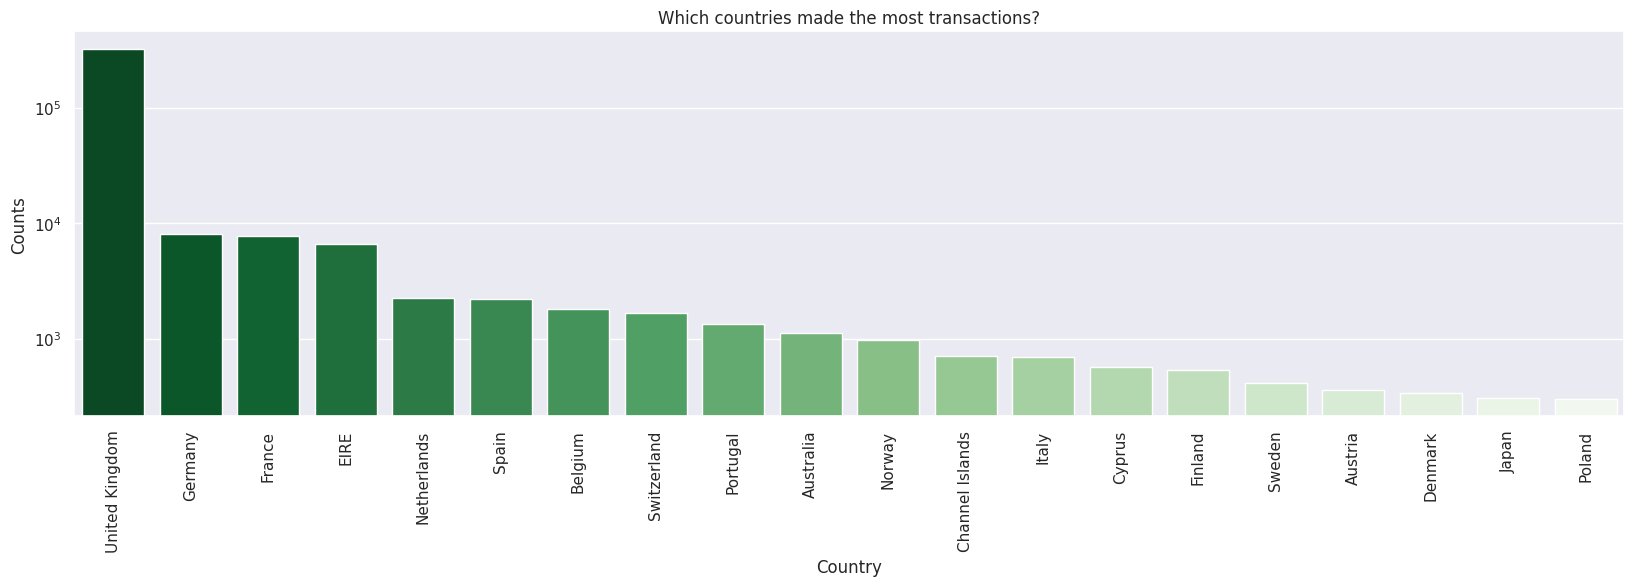

In [151]:
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
# Pass x and y as keyword arguments to sns.barplot
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Greens_r") # Changed to use keyword arguments
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

We can see that the retailer sells almost all products in the UK, followed by many european countries. How many percentage of entries are inside UK?

In [152]:
data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100

89.10192031784572

Let's create a feature to indicate inside or outside of the UK:

In [153]:
data["UK"] = np.where(data.Country == "United Kingdom", 1, 0)

In [154]:
data.UnitPrice.describe()

,UnitPrice
count,362440.000000
mean,2.885355
std,4.361812
min,0.000000
25%,1.250000
50%,1.790000
75%,3.750000
max,649.500000


Again, we have strange occurences: zero unit prices!

In [155]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription,UK
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,asstd design 3d paper stickers,30,0,25,1
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE,set of 6 nativity magnets,26,0,20,0
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia,biscuit tin vintage christmas,29,0,26,0
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands,set of 2 ceramic christmas reindeer,35,0,29,0
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646,Netherlands,polkadot rain hat,18,0,15,0


That's not good again. It's not obvious if they are gifts to customers or not :-( Let's drop them:

In [156]:
data = data.loc[data.UnitPrice > 0].copy()

Text(0.5, 1.0, 'Log-Transformed Distribution of Unit Price')

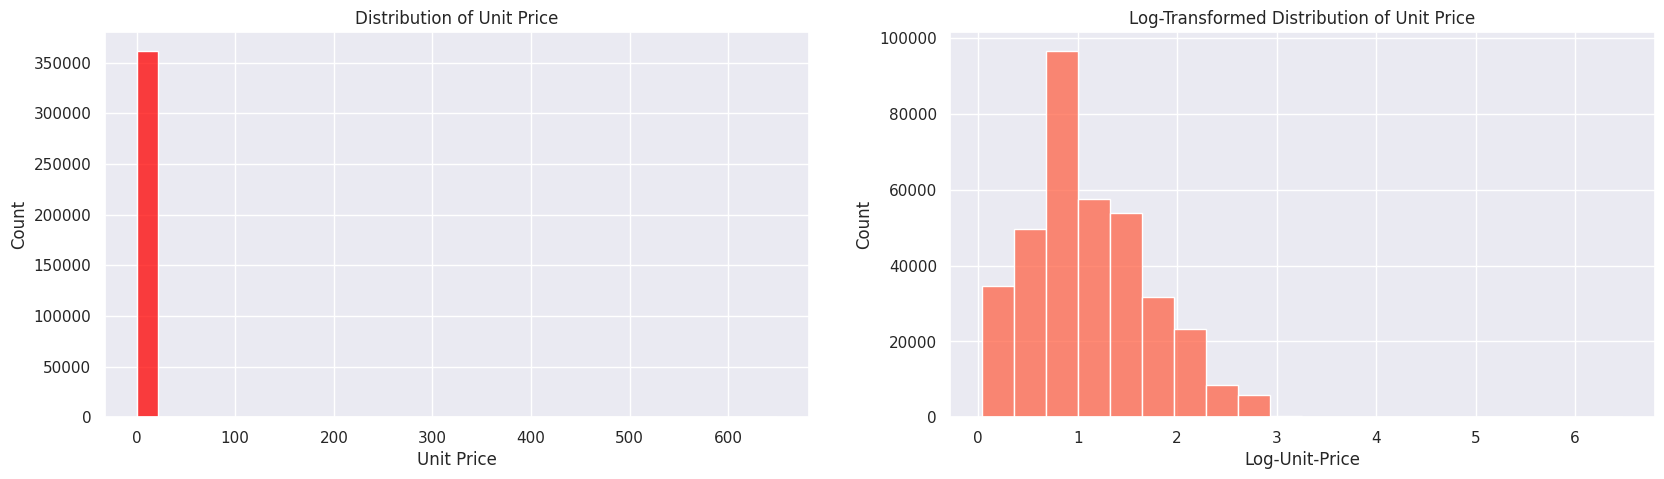

In [157]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Histogram for UnitPrice (without KDE)
sns.histplot(data["UnitPrice"], ax=ax[0], bins=30, color="red")
ax[0].set_xlabel("Unit Price")
ax[0].set_ylabel("Count")
ax[0].set_title("Distribution of Unit Price")

# Histogram for Log-Transformed UnitPrice
sns.histplot(np.log(data["UnitPrice"] + 1), ax=ax[1], bins=20, color="tomato")  # Adding 1 to avoid log(0) errors
ax[1].set_xlabel("Log-Unit-Price")
ax[1].set_ylabel("Count")
ax[1].set_title("Log-Transformed Distribution of Unit Price")



In [158]:
np.exp(-2)

0.1353352832366127

In [159]:
np.exp(3)

20.085536923187668

In [160]:
np.quantile(data.UnitPrice, 0.95)

8.5

In [161]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

### Quantities <a class="anchor" id="quantities"></a>

Ok, the most important one - the target. Let's take a look at its distribution:

In [162]:
data.Quantity.describe()

,Quantity
count,361608.000000
mean,13.024112
std,187.566510
min,1.000000
25%,2.000000
50%,6.000000
75%,12.000000
max,80995.000000


Ok, most products are sold in quantities from 1 to 12. But, we have extreme, unrealistic outliers again:

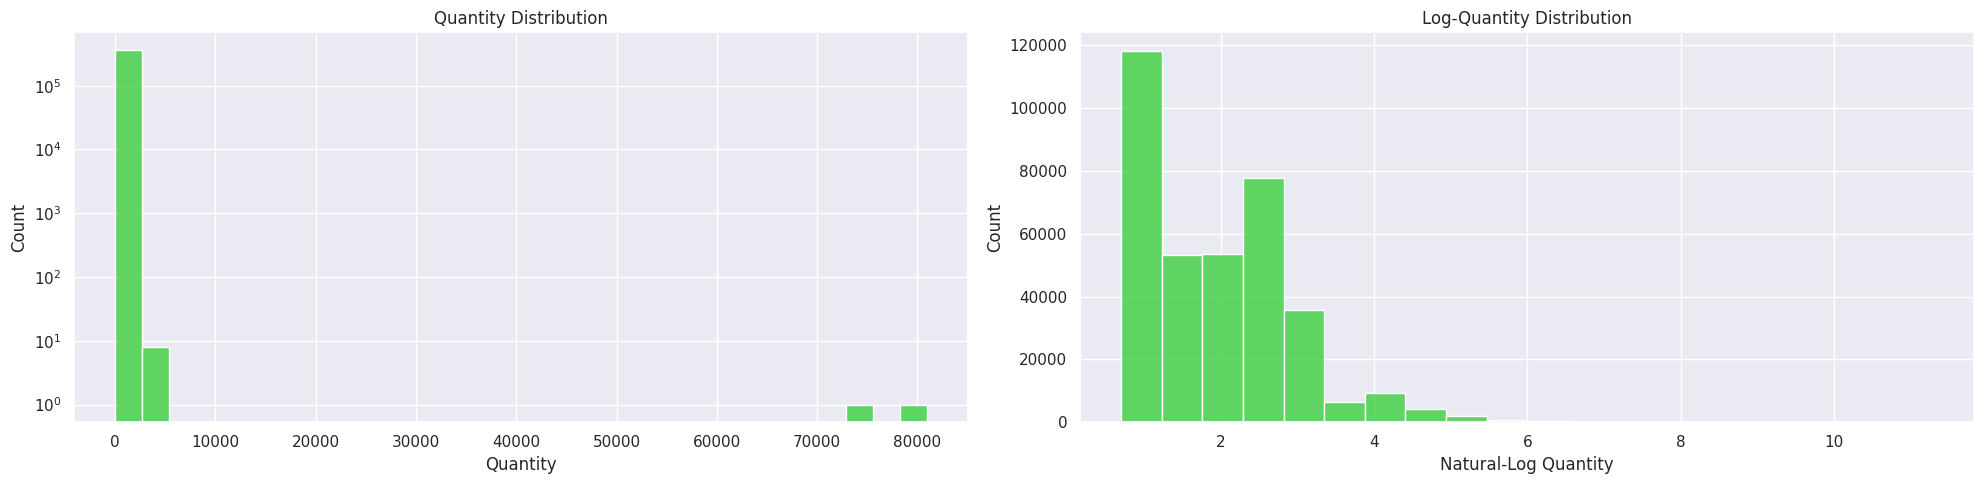

In [163]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Histogram for Quantity (without KDE)
sns.histplot(data["Quantity"], ax=ax[0], bins=30, color="limegreen")
ax[0].set_title("Quantity Distribution")
ax[0].set_xlabel("Quantity")
ax[0].set_ylabel("Count")
ax[0].set_yscale("log")  # Apply log scale to Y-axis

# Histogram for Log-Transformed Quantity
sns.histplot(np.log(data["Quantity"] + 1), ax=ax[1], bins=20, color="limegreen")  # Avoid log(0) error
ax[1].set_title("Log-Quantity Distribution")
ax[1].set_xlabel("Natural-Log Quantity")
ax[1].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [164]:
np.exp(4)

54.598150033144236

In [165]:
np.quantile(data.Quantity, 0.95)

36.0

In this case we would still cover more than 95 % of the data!

In [166]:
data = data.loc[data.Quantity < 55].copy()

### Revenues <a class="anchor" id="revenues"></a>

### Conclusion <a class="anchor" id="expconclusion"></a>

## Focus on daily product sales <a class="anchor" id="daily"></a>

As we like to predict the daily amount of product sales, we need to compute a daily aggregation of this data. For this purpose we need to extract temporal features out of the InvoiceDate. In addition we can compute the revenue gained by a transaction using the unit price and the quantity:

In [167]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
# The 'week' attribute is deprecated, use isocalendar().week instead
data["Week"] = data.InvoiceDate.dt.isocalendar().week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [168]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

In [169]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [170]:
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,195853.000000,195853.000000
mean,14.964244,28.181114
std,18.809496,43.938183
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.600000
max,411.000000,1266.300000


As we can see by the min and max values the **target variable shows extreme outliers**.  If we would like to use it as targets, we **should exclude them as they will mislead our validation. As I like to use early stopping this will directly influence training of predictive models as well**.  

In [171]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 88.48000000001048)


In [172]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


Let's **only use target ranges data that are occupied by  90 % of the data entries**. This is a first and easy strategy to exclude heavy outliers but we should always be aware of the fact that we have lost some information given by the remaining % we have excluded. It could be nice and useful in general to understand and analyse what has caused these outliers.

In [173]:
samples = daily_data.shape[0]

In [174]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

How much entries have we lost?

In [175]:
samples - daily_data.shape[0]

5258

Let's take a look at the remaining distributions of daily quantities:

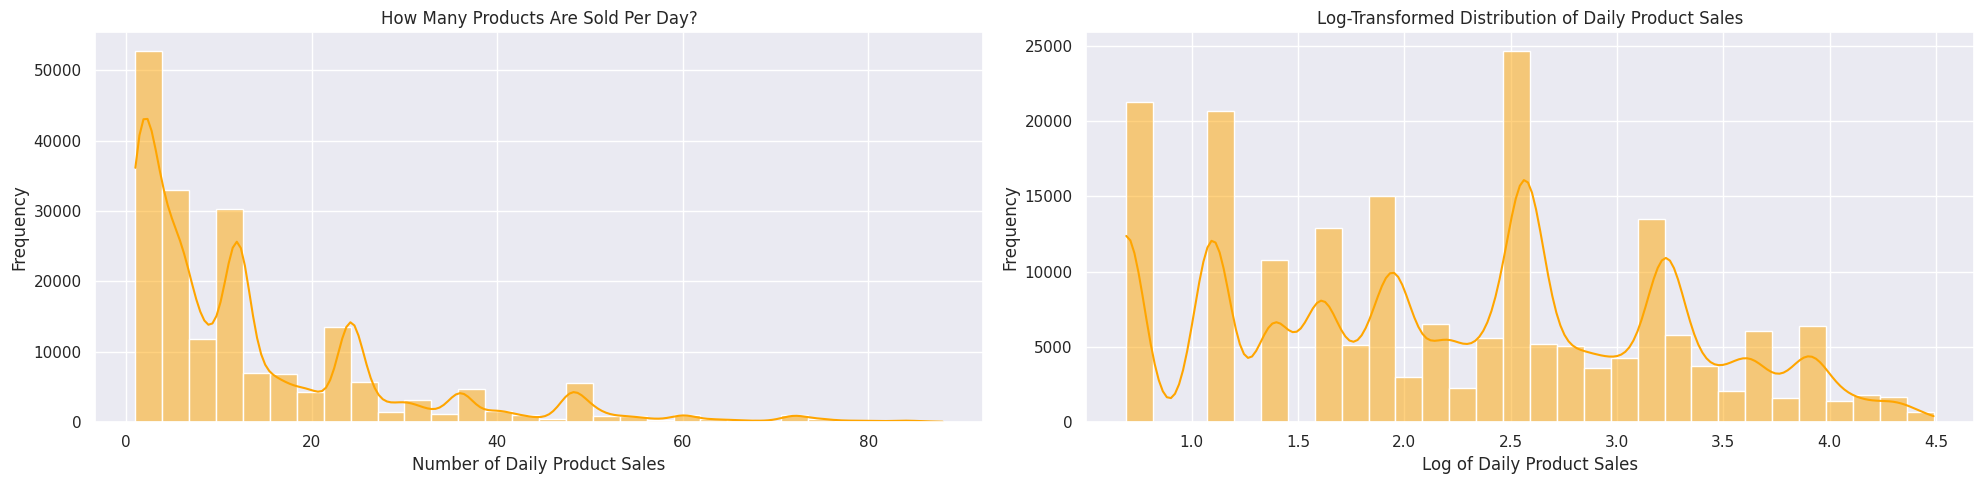

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Histogram + KDE for daily product sales
sns.histplot(daily_data["Quantity"].values, kde=True, ax=ax[0], color="Orange", bins=30)
ax[0].set_xlabel("Number of Daily Product Sales")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How Many Products Are Sold Per Day?")

# Histogram + KDE for Log-Transformed daily product sales
sns.histplot(np.log(daily_data["Quantity"].values + 1), kde=True, ax=ax[1], color="Orange", bins=30)  # Adding +1 to avoid log(0)
ax[1].set_xlabel("Log of Daily Product Sales")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Log-Transformed Distribution of Daily Product Sales")

# Adjust layout
plt.tight_layout()
plt.show()


We can see that the distributions are **right skewed. Lower values are more common**. In addition the daily sales quantities seem to be **multimodal**. A daily sale of 1 is common as well as a quantity of 12 and 24. This pattern is very interesting and leads to the conclusion that quantities are often divisible by 2 or 3. In a nutshell we can say that specific products are often bought as single quantites or in a small bunch.

## How to predict daily product sales? <a class="anchor" id="model"></a>

In this kernel I like to use [catboost ](https://catboost.ai/) as predictive model. The prediction of daily quantities and revenues are both regression tasks and consequently I will use the catboost regressor. The loss and metric I like to use is the [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE):

$$ E = \sqrt{ \frac{1}{N}\sum_{n=1}^{N} (t_{n} - y_{n})^{2}}$$

It computes the error between the target value $t_{n}$ and the predicted value $y_{n}$ per sample, takes the square to make sure that both, positive and negative deviations, contribute to the sum the same way. Then the mean is taken by dividing with the total amount $N$ of samples (entries) in the data. And finally to obtain an impression of the error for single predictions, the root is taken. What should we keep in mind when working with this loss and metric function? :-) It's heavily influenced by outliers! **If we have some predictions that are far away from the targets, they will guide the mean towards higher values as well. Hence it could be that we will make nice predictions for a majority of samples but the RMSE is still high due to high errors for a minority of samples**.

### Validation strategy

As the **data covers only one year and we have a high increase of sold products during pre-christmas period**, we need to select validation data carefully. I will start with validation data that covers at least 8 full weeks (+ remaining days). After generating new features by exploring the data, I will use a sliding window time series validation that should help us to understand if the model is able to solve the prediction task during both times: pre-christmas season and non-christmas season.

In [177]:
class CatHyperparameter:

    def __init__(self,
                 loss="RMSE",
                 metric="RMSE",
                 iterations=1000,
                 max_depth=4,
                 l2_leaf_reg=3,
                 #learning_rate=0.5,
                 seed=0):
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        #self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

**Catmodel class**

This model obtains a train & validation pool as data or pandas dataframes for features X and targets y together with a week. It's the first week of our validation data and all other weeks above are used as well. It trains the model and can show learning process as well as feature importances and some figures for result analysis. It's the fastest choice you can make for playing around.

In [178]:
class Catmodel:

    def __init__(self, name, params):
        self.name = name
        self.params = params

    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool

    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)

    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )

    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))

    def score(self):
        return self.model.score(self.val_pool)

    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)

    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))

    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax

    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))

    def predict(self, x):
        return self.model.predict(x)

    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )



**Hyperparameter-Search class**

This is a class for hyperparameter search that uses Bayesian Optimization and Gaussian Process Regression to find optimal hyperparameters. I decided to use this method as the computation of the score for one catfamily model may be expensive. In this case bayesian optimization could be a plus. As this optimization methods takes some time as well you should try random search as well as this may be faster.

In [179]:
!pip install GPyOpt

In [180]:
import GPyOpt

class Hypertuner:

    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None

    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()

    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))

    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

**Time series validation Catfamily**

This model holds the information about how to split the data into validation chunks and it organizes the training with sliding window validation. Furthermore it can return a score as the mean over all RMSE scores of its models.

In [181]:
class CatFamily:

    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params

    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)

    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool

    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)

    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score

    def score(self):
        return np.mean(self.model_scores)

    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")

### Baseline model & result analysis  <a class="anchor" id="baseline"></a>

Let's see how good this model performs without feature engineering and hyperparameter search:

In [182]:
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [183]:
week = daily_data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

Validation after week 49
Validation starts at timepoint 2010-12-06 00:00:00


In [184]:
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("baseline", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 65


In [185]:
float  # Instead of np.float
np.float64  # If NumPy data type is needed


numpy.float64

In [186]:
import numpy as np
print(np.__version__)  # Check NumPy version


1.26.4


In [187]:
pip install --upgrade numpy


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.12.0 requires numpy<1.29.0,>=1.22.4, but you have numpy 2.2.4 which is incompatible.
gpy 1.13.2 requires numpy<2.0.0,>=1.7, but you have numpy 2.2.4 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
thinc 8.2.5 requires

In [188]:
class Catmodel:

    def __init__(self, name, params):
        self.name = name
        self.params = params

    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool

    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != np.float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)

    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )

    def learn(self, plot=False): # Added the missing learn method
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot)
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))

    def score(self):
        return self.model.score(self.val_pool)

    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)

    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))

    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax

    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))

    def predict(self, x):
        return self.model.predict(x)

    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )

In [189]:
import numpy as np
import warnings

# Fix np.float issue for compatibility
if not hasattr(np, 'float'):
    np.float = float  # Temporary fix

# Ensure log transformation is safe
daily_data["Quantity"] = np.log1p(daily_data["Quantity"])  # Avoid -inf errors

# Define target variable
y = daily_data["Quantity"].dropna()
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1).loc[y.index]

# Ensure y is not empty
if y.empty:
    raise ValueError("Error: y (target variable) is empty after preprocessing.")

# Define model parameters
params = CatHyperparameter()
model = Catmodel("baseline", params)

# Ensure 'week' is defined correctly and adjusted for valid data points
week = daily_data["Week"].quantile(0.9)  # Use 90% quantile of Week as cutoff
#week = daily_data["Week"] if "Week" in daily_data.columns else None

# Train the model
model.set_data(X, y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 67


In [190]:
model.score()

0.19663725323158343

Median absolute error: 0.3153615374242631


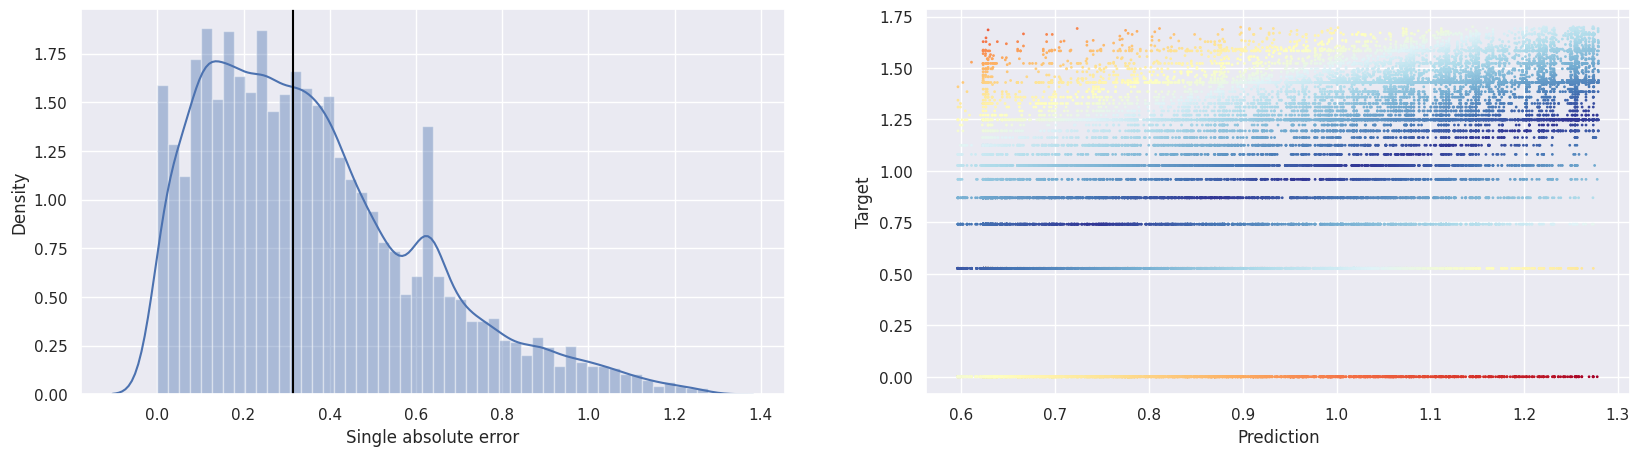

In [191]:
model.show_val_results();

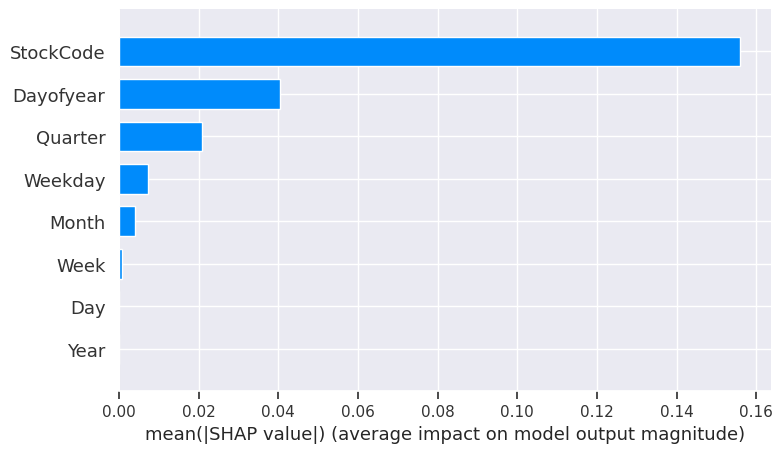

In [192]:
model.show_importances()

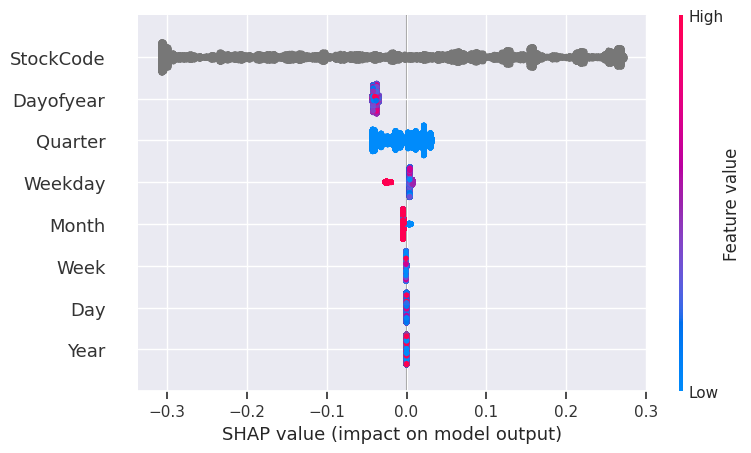

In [193]:
model.show_importances(kind=None)

The model has complex ctrs, so the SHAP values will be calculated approximately.

In [194]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

0.9427832777770774

In [195]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

0.8770816297032766

In [196]:
products = pd.DataFrame(index=data.loc[data.Week < week].StockCode.unique(), columns = ["MedianPrice"])

products["MedianPrice"] = data.loc[data.Week < week].groupby("StockCode").UnitPrice.median()
products["MedianQuantities"] = data.loc[data.Week < week].groupby("StockCode").Quantity.median()
products["Customers"] = data.loc[data.Week < week].groupby("StockCode").CustomerID.nunique()
products["DescriptionLength"] = data.loc[data.Week < week].groupby("StockCode").DescriptionLength.median()
#products["StockCode"] = products.index.values
org_cols = np.copy(products.columns.values)
products.head()

,MedianPrice,MedianQuantities,Customers,DescriptionLength
22386,2.08,10.0,333,23.0
21499,0.42,25.0,159,18.0
21498,0.42,25.0,219,19.0
22379,2.10,5.0,170,24.0
20718,1.25,10.0,217,25.0


In [197]:
for col in org_cols:
    if col != "StockCode":
        products[col] = boxcox(products[col])[0]

Text(0, 0.5, 'Boxcox-Median-Quantities')

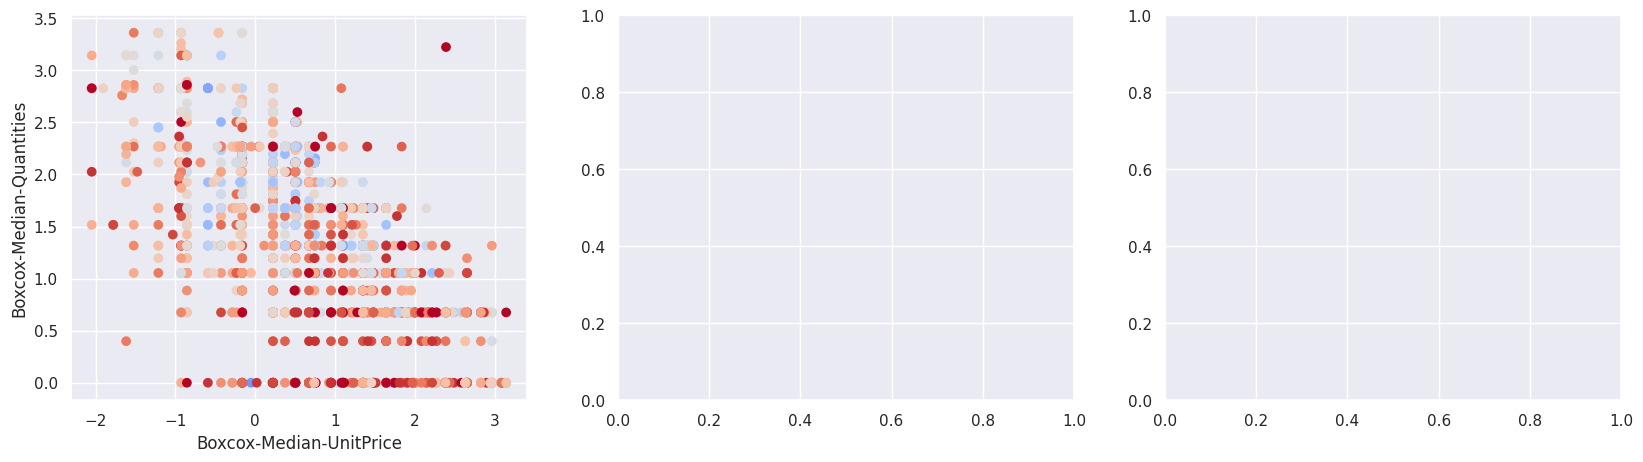

In [198]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(products.MedianPrice.values, products.MedianQuantities.values,
           c=products.Customers.values, cmap="coolwarm_r")
ax[0].set_xlabel("Boxcox-Median-UnitPrice")
ax[0].set_ylabel("Boxcox-Median-Quantities")

In [199]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [200]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data["ProductType"] = daily_data.StockCode.map(products.cluster)
daily_data.ProductType = daily_data.ProductType.astype("object")
daily_data.head()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x78cc276f5940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue,ProductType
0,2010-12-01,2010,4,12,48,2,335,1,10002,1.628131,51.00,19.0
1,2010-12-01,2010,4,12,48,2,335,1,10125,0.526589,1.70,19.0
2,2010-12-01,2010,4,12,48,2,335,1,10133,0.959135,4.25,22.0
3,2010-12-01,2010,4,12,48,2,335,1,16014,1.194706,4.20,22.0
4,2010-12-01,2010,4,12,48,2,335,1,16016,1.194706,8.50,19.0


In [201]:
daily_data["KnownStockCodeUnitPriceMedian"] = daily_data.StockCode.map(
    data.groupby("StockCode").UnitPrice.median())

known_price_iqr = data.groupby("StockCode").UnitPrice.quantile(0.75)
known_price_iqr -= data.groupby("StockCode").UnitPrice.quantile(0.25)
daily_data["KnownStockCodeUnitPriceIQR"] = daily_data.StockCode.map(known_price_iqr)

In [202]:
to_group = ["StockCode", "Year", "Month", "Week", "Weekday"]

daily_data = daily_data.set_index(to_group)
daily_data["KnownStockCodePrice_WW_median"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.median())
daily_data["KnownStockCodePrice_WW_mean"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2)))
daily_data["KnownStockCodePrice_WW_std"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.std().apply(lambda l: np.round(l, 2)))

daily_data = daily_data.reset_index()

In [203]:
daily_data.head()

,StockCode,Year,Month,Week,Weekday,Date,Quarter,Dayofyear,Day,Quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std
0,10002,2010,12,48,2,2010-12-01,4,335,1,1.628131,51.00,19.0,0.85,0.0000,0.85,0.85,0.0
1,10125,2010,12,48,2,2010-12-01,4,335,1,0.526589,1.70,19.0,0.85,0.0000,0.85,0.85,NaN
2,10133,2010,12,48,2,2010-12-01,4,335,1,0.959135,4.25,22.0,0.42,0.3225,0.85,0.85,NaN
3,16014,2010,12,48,2,2010-12-01,4,335,1,1.194706,4.20,22.0,0.42,0.0000,0.42,0.42,NaN
4,16016,2010,12,48,2,2010-12-01,4,335,1,1.194706,8.50,19.0,0.85,0.0000,0.85,0.85,NaN


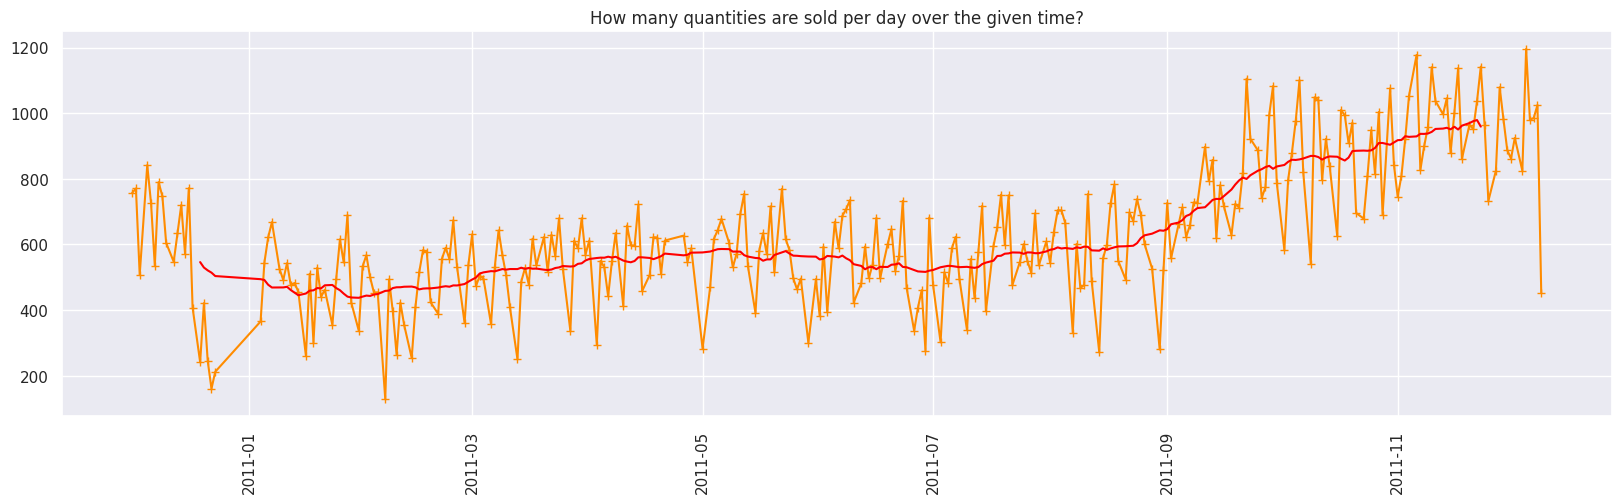

In [204]:
plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

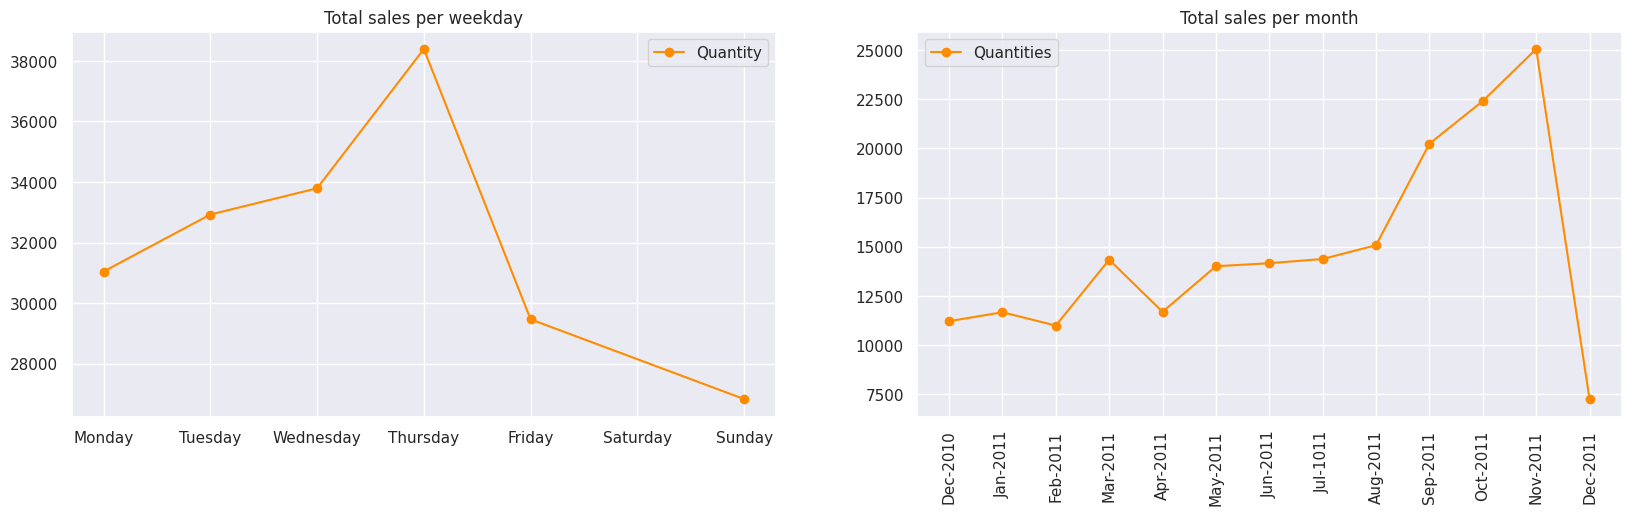

In [205]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011",
             "Dec-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

In [206]:
daily_data["PreChristmas"] = (daily_data.Dayofyear <= 358) & (daily_data.Dayofyear >= 243)

In [207]:
for col in ["Weekday", "Month", "Quarter"]:
    daily_data = daily_data.set_index(col)
    daily_data[col+"Quantity_mean"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.mean()
    daily_data[col+"Quantity_median"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.median()
    daily_data[col+"Quantity_mean_median_diff"] = daily_data[col+"Quantity_mean"] - daily_data[col+"Quantity_median"]
    daily_data[col+"Quantity_IQR"] = daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.75) - daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.25)
    daily_data = daily_data.reset_index()
daily_data.head()

,Quarter,Month,Weekday,StockCode,Year,Week,Date,Dayofyear,Day,Quantity,...,WeekdayQuantity_mean_median_diff,WeekdayQuantity_IQR,MonthQuantity_mean,MonthQuantity_median,MonthQuantity_mean_median_diff,MonthQuantity_IQR,QuarterQuantity_mean,QuarterQuantity_median,QuarterQuantity_mean_median_diff,QuarterQuantity_IQR
0,4,12,2,10002,2010,48,2010-12-01,335,1,1.628131,...,-0.171712,0.643951,NaN,NaN,NaN,NaN,1.009287,1.124748,-0.115461,0.643951
1,4,12,2,10125,2010,48,2010-12-01,335,1,0.526589,...,-0.171712,0.643951,NaN,NaN,NaN,NaN,1.009287,1.124748,-0.115461,0.643951
2,4,12,2,10133,2010,48,2010-12-01,335,1,0.959135,...,-0.171712,0.643951,NaN,NaN,NaN,NaN,1.009287,1.124748,-0.115461,0.643951
3,4,12,2,16014,2010,48,2010-12-01,335,1,1.194706,...,-0.171712,0.643951,NaN,NaN,NaN,NaN,1.009287,1.124748,-0.115461,0.643951
4,4,12,2,16016,2010,48,2010-12-01,335,1,1.194706,...,-0.171712,0.643951,NaN,NaN,NaN,NaN,1.009287,1.124748,-0.115461,0.643951


In [208]:
to_group = ["StockCode", "PreChristmas"]
daily_data = daily_data.set_index(to_group)
daily_data["PreChristmasMeanQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.mean().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasMedianQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.median().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasStdQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.std().apply(lambda l: np.round(l, 1))
daily_data = daily_data.reset_index()

In [209]:
for delta in range(1,4):
    to_group = ["Week","Weekday","ProductType"]
    daily_data = daily_data.set_index(to_group)

    daily_data["QuantityProducttypeWeekWeekdayLag_" + str(delta) + "_median"] = daily_data.groupby(
        to_group).Quantity.median().apply(lambda l: np.round(l,1)).shift(delta)

    daily_data = daily_data.reset_index()
    daily_data.loc[daily_data.Week >= (week+delta),
                   "QuantityProductTypeWeekWeekdayLag_" + str(delta) + "_median"] = np.nan

In [210]:
data["ProductType"] = data.StockCode.map(products.cluster)

In [211]:
daily_data["TransactionsPerProductType"] = daily_data.ProductType.map(data.loc[data.Week < week].groupby("ProductType").InvoiceNo.nunique())

In [212]:
delta = 1
to_group = ["Week", "Weekday", "ProductType"]
daily_data = daily_data.set_index(to_group)
daily_data["DummyWeekWeekdayAttraction"] = data.groupby(to_group).CustomerID.nunique()
daily_data["DummyWeekWeekdayMeanUnitPrice"] = data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2))

daily_data["WeekWeekdayAttraction_Lag1"] = daily_data["DummyWeekWeekdayAttraction"].shift(1)
daily_data["WeekWeekdayMeanUnitPrice_Lag1"] = daily_data["DummyWeekWeekdayMeanUnitPrice"].shift(1)

daily_data = daily_data.reset_index()
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayAttraction_Lag1"] = np.nan
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayMeanUnitPrice_Lag1"] = np.nan
daily_data = daily_data.drop(["DummyWeekWeekdayAttraction", "DummyWeekWeekdayMeanUnitPrice"], axis=1)

In [213]:
daily_data["TransactionsPerStockCode"] = daily_data.StockCode.map(
    data.loc[data.Week < week].groupby("StockCode").InvoiceNo.nunique())

In [214]:
daily_data.head()

,Week,Weekday,ProductType,StockCode,PreChristmas,Quarter,Month,Year,Date,Dayofyear,...,QuantityProducttypeWeekWeekdayLag_1_median,QuantityProductTypeWeekWeekdayLag_1_median,QuantityProducttypeWeekWeekdayLag_2_median,QuantityProductTypeWeekWeekdayLag_2_median,QuantityProducttypeWeekWeekdayLag_3_median,QuantityProductTypeWeekWeekdayLag_3_median,TransactionsPerProductType,WeekWeekdayAttraction_Lag1,WeekWeekdayMeanUnitPrice_Lag1,TransactionsPerStockCode
0,48,2,19.0,10002,True,4,12,2010,2010-12-01,335,...,1.1,NaN,1.0,NaN,1.2,NaN,3181.0,NaN,NaN,29.0
1,48,2,19.0,10125,True,4,12,2010,2010-12-01,335,...,1.1,NaN,1.0,NaN,1.2,NaN,3181.0,39.0,1.16,48.0
2,48,2,22.0,10133,True,4,12,2010,2010-12-01,335,...,1.0,NaN,0.9,NaN,1.2,NaN,2120.0,39.0,1.16,103.0
3,48,2,22.0,16014,True,4,12,2010,2010-12-01,335,...,1.0,NaN,0.9,NaN,1.2,NaN,2120.0,19.0,0.54,34.0
4,48,2,19.0,16016,True,4,12,2010,2010-12-01,335,...,1.1,NaN,1.0,NaN,1.2,NaN,3181.0,19.0,0.54,49.0


In [215]:
daily_data["CustomersPerWeekday"] = daily_data.Month.map(
    data.loc[data.Week < week].groupby("Weekday").CustomerID.nunique())

In [216]:
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("new_features_1", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

new_features_1, early-stopped model tree count 176


In [217]:
model.score()

0.3930196566277946

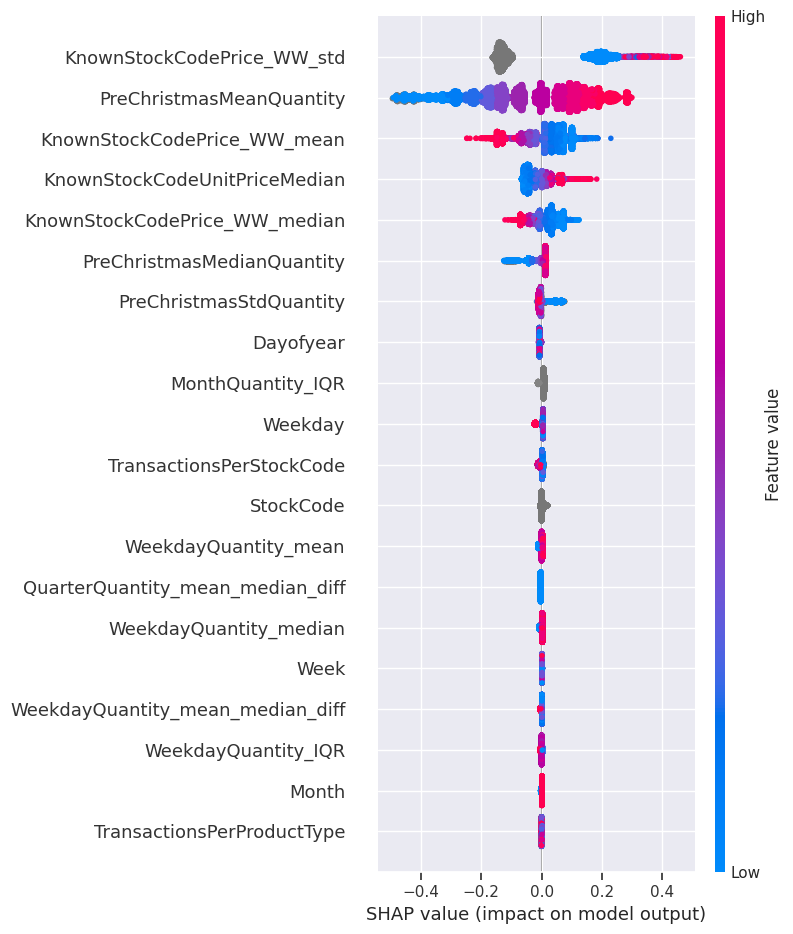

In [218]:
model.show_importances(kind=None)

Median absolute error: 0.22787664873279123


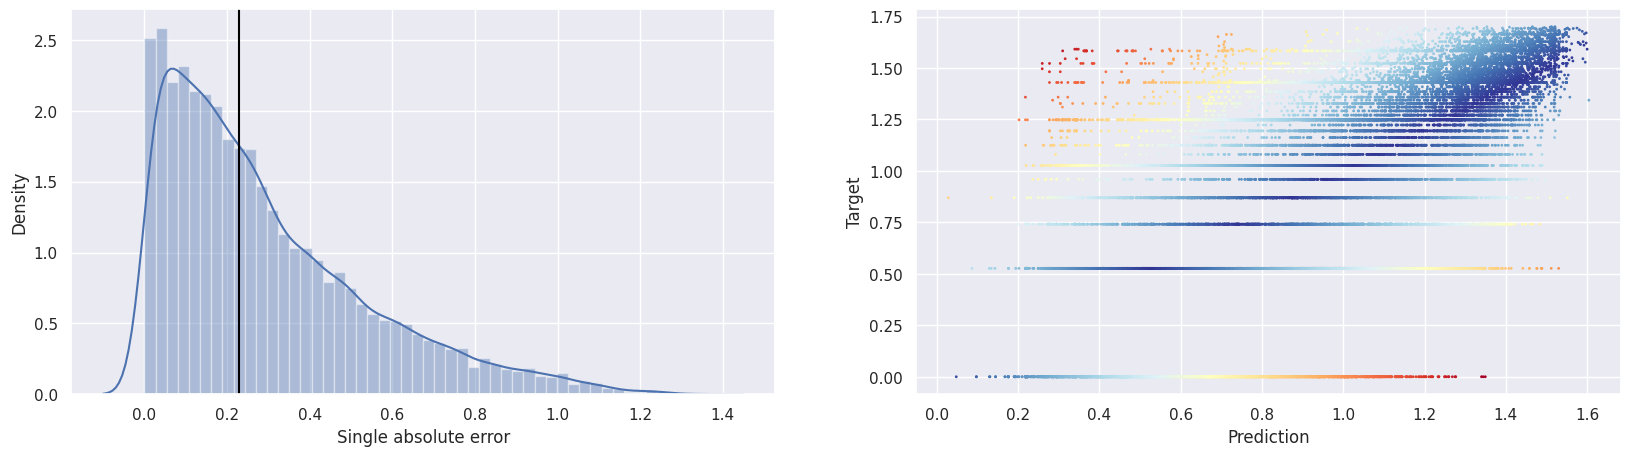

In [219]:
model.show_val_results();

In [220]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

0.7439470511952065

In [221]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

0.6336812515654398

new_features_1, early-stopped model tree count 151
new_features_1, early-stopped model tree count 151
new_features_1, early-stopped model tree count 151
new_features_1, early-stopped model tree count 399
new_features_1, early-stopped model tree count 91
new_features_1, early-stopped model tree count 354


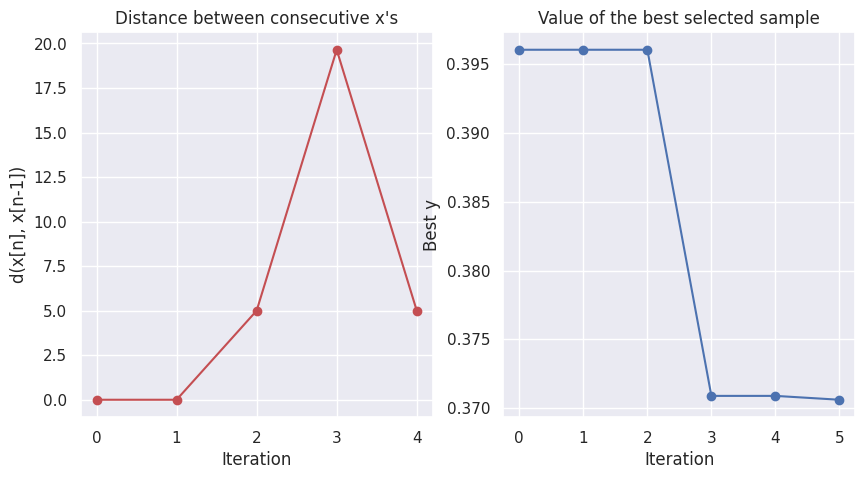

Optimal depth is 1.0 and optimal l2-leaf-reg is 1.0
Optimal RMSE: 0.3706058078891049


In [225]:
search = Hypertuner(model)
search.learn()